<div style="color: #ffffff; background-color: #2979ff; border-bottom: 1px solid #004ecb; padding: 2em;">
<b style="font-size: 20pt;">TP4: Stochastic gradient & co</b> <br> <br>
<b style="font-size: 15pt; color: #bbdefb">Ensimag 2A — Special grading lab</b>
</div>

**Student: MOhamed Ahmed Mohamed Lemine**

In [87]:
# Automatic reload of local libraries
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


>**[0. Context](#0.-Context)**<br>
**[I. Introduction](#I.-Introduction)**<br> 
**[II. The optimization problem](#II.-The-optimization-problem)**<br>
**[III. Implementing the solvers](#III.-Implementing-the-solvers)**<br>
&nbsp; &nbsp; &nbsp;[GD (Gradient descent)](#GD-(Gradient-descent))<br>
&nbsp; &nbsp; &nbsp;[SGD (Stochastic Gradient Descent)](#SGD-(Stochastic-Gradient-Descent)<br>
&nbsp; &nbsp; &nbsp;[SAGA (Stochastic Average Gradient "Amélioré")](#SAGA-(Stochastic-Average-Gradient-"Amélioré")<br>
&nbsp; &nbsp; &nbsp;[Comparison](#Comparison)<br>
**[IV. Regularization](#IV.-Regularization)**<br>
**[V. Further development](#V.-Further-development)**<br>

In this lab, you will implement optimization algorithms that we've studied together and use them to fit a logistic regression classification model. Parts of this lab intersect TP2 and 3.

You will be implementing a simplified version of [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

Part of the work has already been done for you (see the `./lib` folder), so you'll only have to implement the `##### TODO (i) #####` sections of the code. 

Report in groups of 1 to 2 students (1 student advised). <br>

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>0. Context</h1>
</div>

As in the last session, we shall study the logistic regression of a data matrix to binary-encoded labels (see the introduction section).
This time, to avoid to compute costly gradients, one may try to consider the data points (the rows of $A$) as random variables sampled via an uniform distribution. They may then consider a minimization proflem of a loss $L: x\to L(x)$, in which the loss is not deterministic anymore, it corresponds to the average loss with respect to the random data points $a$ of "per-sample losses" $F$:
$$
L(x) := \mathbb{E}_{a\sim\mathbb{P}}[F(a;x)]
$$

Since the true distribution generating the randomness of $a$ is not known in most cases, one may approximate the above expression with the data points of the design matrix $A$, sampled from its rows ($\forall i\le n$: $a_i:=(A)_{i, :}$) randomly:
$$
L(x) \approx \underbrace{\mathbb{E}_{i\sim\mathcal{U}(0, n)}[F(a_i;x)]}_{=:L_n(x)}
$$
Minimizing this functional is called the empirical risk minimization.

One very good and useful property is that the gradient of this estimator is, at least, unbiased for the empirical distribution:
$$
\underbrace{\nabla_x L(x) = \mathbb{E}_{a\sim\mathbb{P}}[\nabla_x F(a;x)]}_{\text{"true" gradient(s)}} \approx \underbrace{\nabla_x L_n(x) = \nabla_x \left(\mathbb{E}_{i\sim\mathcal{U}(0, n)}[F(a_i;x)]\right) = \mathbb{E}_{i\sim\mathcal{U}(0, n)}[\nabla_x F(a_i;x)]}_{\text{estimation}}
$$

So the main idea of this last session is to implement an algorithm performing gradient steps only in the "per sample" loss.

You will implement three algorithms, and send your reports by email in a zip format containing the filled files and the notebook, with **as much comments on your attempts as you can write**.

You must discuss your choices, and write good readable code. The goal is to compare the three methods with valid implementations:

* the first one is the vanilla Gradient Descent, taking the average of the gradients at each step
* second is the stochastic gradient, taking at each step a random sample
* third is the saga algorithm, which improves on sgd by relying on a memory of some past gradients. 

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>I. Introduction</h1>
</div>

As in previous labs, we consider the [Student Performance](http://archive.ics.uci.edu/ml/datasets/Student+Performance) dataset. This dataset contains student demographic, social, school-related features, how many classes they've missed, etc. 

The goal we give ourselves is to predict whether a student will pass (final grade > 12).

We denote $A \in \mathcal{M}_{n,d}(\mathbb{R})$ the feature matrix, containing $n$ samples with $d$ features, and $b \in \{-1,1\}^n$ the label vector where $-1$ encodes `fail` and $1$ encodes `pass`.

The data has already been preprocessed: You can check ```lib/datasets.py``` if you're curious. The following loads the dataset:

In [88]:
from lib.datasets import load_student_data

A_train, A_test, b_train, b_test = load_student_data('data/student-mat.csv', split=0.25)


As mentioned previously, you're going to implement a simplified version of [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). So let's first see the type of output it is supposed to give. 

<div style="background-color: #e1f5fe; border-left: 5px solid #2962ff; padding: 0.5em;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul style="color: black">
        <li> Import the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">sklearn.linear_model.LogisticRegression </a> class. </li>
        <li> Create an instance of sklearn's logistic regression classifiers with SAGA as its solver. (You may decrease the target accuracy to 0.001) </li>
        <li> Fit the classifier on the training data and compute the score of the fitted model on the test set.</li>
    </ul>
</div>

In [89]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [90]:
model = LogisticRegression(tol=0.001, solver="saga")

In [91]:
model.fit(A_train, b_train)

LogisticRegression(solver='saga', tol=0.001)

In [92]:
model.score(A_test, b_test)

0.9191919191919192

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>II. The optimization problem</h1>
</div>

Logistic regression consists in finding the parameter $x \in \mathbb{R}^d$ that best fits:
$$
b_i = \begin{cases}
\phantom{-}1 \ \textrm{ if }\ \langle a_{i}, x\rangle \ge 0 \\
-1 \ \textrm{ if }\ \langle a_{i}, x\rangle < 0 
\end{cases}
$$
for all the samples $i$ of the training set (where $a_i$ is the $i^{th}$ line of $A$ and $b_i$ the $i^{th}$ element of $b$). To measure this fit, logistic regression chooses the following loss:

$$
\textrm{LogisticLoss}(b_i, \left\langle a_{i}, x\right\rangle ) = \log \left(1+\exp \left(-b_{i}\left\langle a_{i}, x\right\rangle\right)\right) 
$$

The corresponding optimization problem we will consider is the following:

<div style="background-color: #eceff1; border-left: 0px solid #78909c; padding: 2em; border-radius: 5px; color: black"> 

Minimization of the empirical risk $f$ of the $L_2$-regularized logistic regression model, on the dataset $(A_{\textrm{train}},b_{\textrm{train}})$:

$$
\begin{aligned}
\textrm{min}_{x\in \mathbb{R}^d} \  f(x) 
\ &= \ \textrm{min}_{x\in \mathbb{R}^d} \ \frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} f_i(x) \\
&= \ \textrm{min}_{x\in \mathbb{R}^d}\frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} \textrm{LogisticLoss}(b_i, \left\langle a_{i}, x\right\rangle ) + \frac{l_2}{2}\|x\|^{2}_2,  
\end{aligned}
$$

where $l_2 \ge 0$ is the regularization parameter.
</div>

To simplify the notation, we'll stop indexing $A$, $b$ and $n$ with "$\textrm{train}$" in the following.

Note that the functions $f_i$s and $f$ are $C^1$ with $L$-Lischitz gradient, with $L \le \frac{\max_i\|a_i\|^2_2}{4} + l_2$ and we can therefore use the following value in our implementation:
```python
L = 0.25 * max(np.linalg.norm(A,2,axis=1))**2 + self.l2
```

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>III. Implementing the solvers</h1>
</div>

To implement gradient methods, we need an oracle that will compute both batch gradients $\nabla f$ and partial gradients $\nabla f_i$.

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;color: black;"> 
<b style="color: #2962ff;">Question:</b>  In the code below, $\nabla f$ has already been implemented.
    <ul style="color: black">
        <li> Complete <b>TODO (1)</b> in <code>lib/linear_model.py</code>.</li>
        <li> Add your code to <code>lib/linear_model.py</code>.</li>
    </ul>
</div>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em;color: black;"> 
<b style="color: #2962ff;">Question:</b>  The solvers backbones have been implemented, study them before filling the code for the little parts.
    <ul style="color: black">
        <li> Read carefuly <code>lib/solvers.py</code>.</li>
    </ul>
</div>

# GD (Gradient descent) 

At iteration k of the GD algorithm, the following update is executed:

$$
x_{k+1} \leftarrow x_{k} - \gamma\nabla f(x_k)
$$

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma$ ensures the convergence of this algorithm ?</li>
        <li> Complete <b>TODO (2)</b> with the correct step size and <b>TODO (3)</b> with the gradient step</li>
        <li> Add your code to <code>lib/gd.py</code>.</li>
    </ul>
</div>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color:black;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

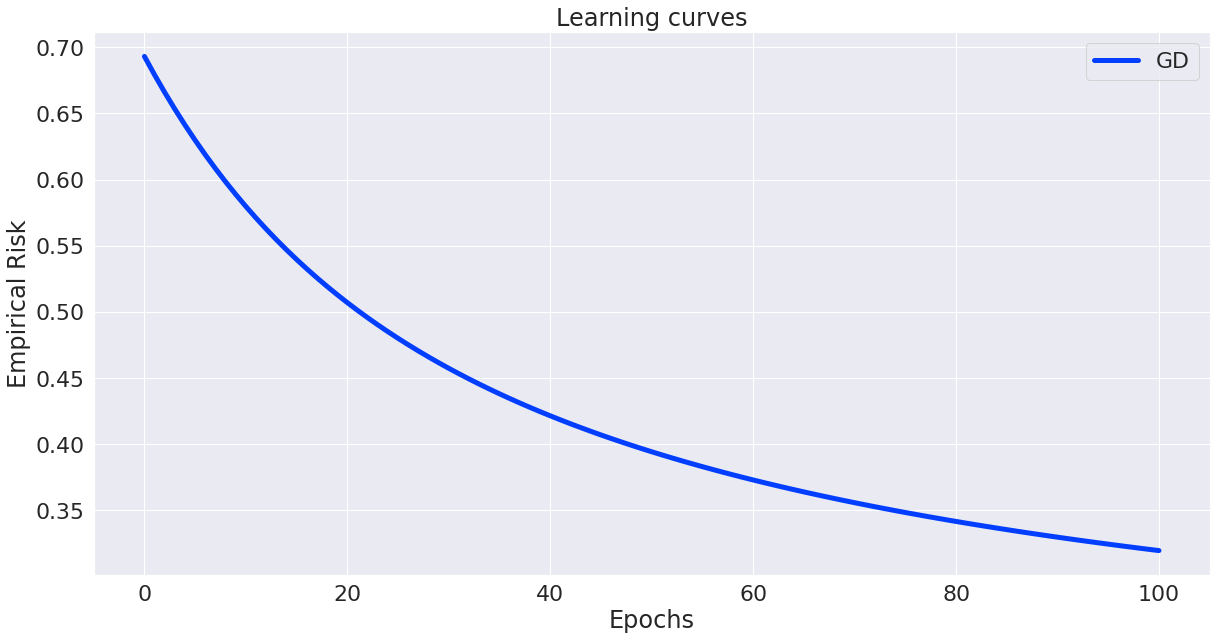

In [93]:
from lib.linear_model import LogisticRegression
from lib.visuals import learning_curve

clf_gd = LogisticRegression(solver='gd', l2=0.01, max_iter=100)
clf_gd.fit(A_train, b_train)

learning_curve(GD=clf_gd)

## le choix du $\gamma$ :

D'après le lemme de descente de gradient, on a la convergence de la méthode de descente de gradient si :


$$\gamma \in ]0, \frac{2}{L}[$$
 et pour la méthode de la recherche linéaire exacte ,  $$\gamma = \frac{1}{L} $$


# SGD (Stochastic Gradient Descent)

At iteration k of the SGD algorithm, the following update is executed:

$$
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\}\\
x_{k+1} \leftarrow x_{k} - \gamma_k \nabla f_i(x_k) \\
\end{cases}
$$

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma_k$ ensures the convergence of this algorithm and under what assumptions? Provide your own line of reasonning, be it by relying on litterature or by trying multiple combinations.</li>
        <li> Complete <b>TODO (4)</b> (both the stepsize functions and the stepping function)</li>
        <li> Add your code to <code>lib/sgd.py</code>.</li>
    </ul>
</div>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

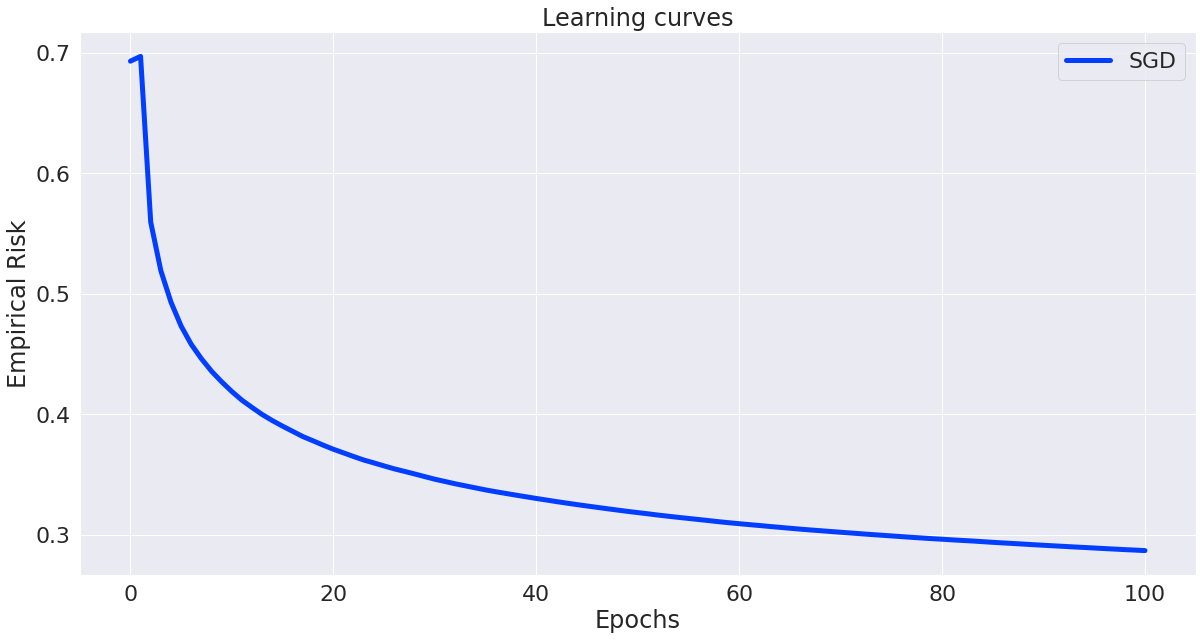

In [94]:
clf_sgd = LogisticRegression(solver='sgd', l2=0.01, max_iter=100*len(b_train))
clf_sgd.fit(A_train, b_train)

learning_curve(SGD=clf_sgd)

In [95]:
## le

# SAGA (Stochastic Average Gradient "Amélioré")

SAGA starts by computing a single batch gradient, then at iteration k, the following update is executed:

$$
\begin{cases}
i \textrm{ chosen randomly in } \{1...n\}\\
x_{k+1} \leftarrow x_{k} - \gamma_k\big(\nabla f_i(x_k) - \alpha_i + \bar{\alpha}\big) \\
\alpha_i \leftarrow \nabla f_i(x) 
\end{cases}
$$

where $(\alpha_j)_{j=1}^n$ are gradients evaluated at previous iterates and $\bar{\alpha}=\frac{1}{n}\sum^n_{j=1}\alpha_j$.


<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b>  
    <ul>
        <li> What stepsize $\gamma_k$ ensures the convergence of this algorithm and under what assumptions (propose ideas, no demonstration needed)?</li>
        <li> Complete <b>TODO (5)</b></li>
        <li> Add your code to <code>lib/saga.py</code>.</li>
    </ul>
</div>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to test your code.
</div>

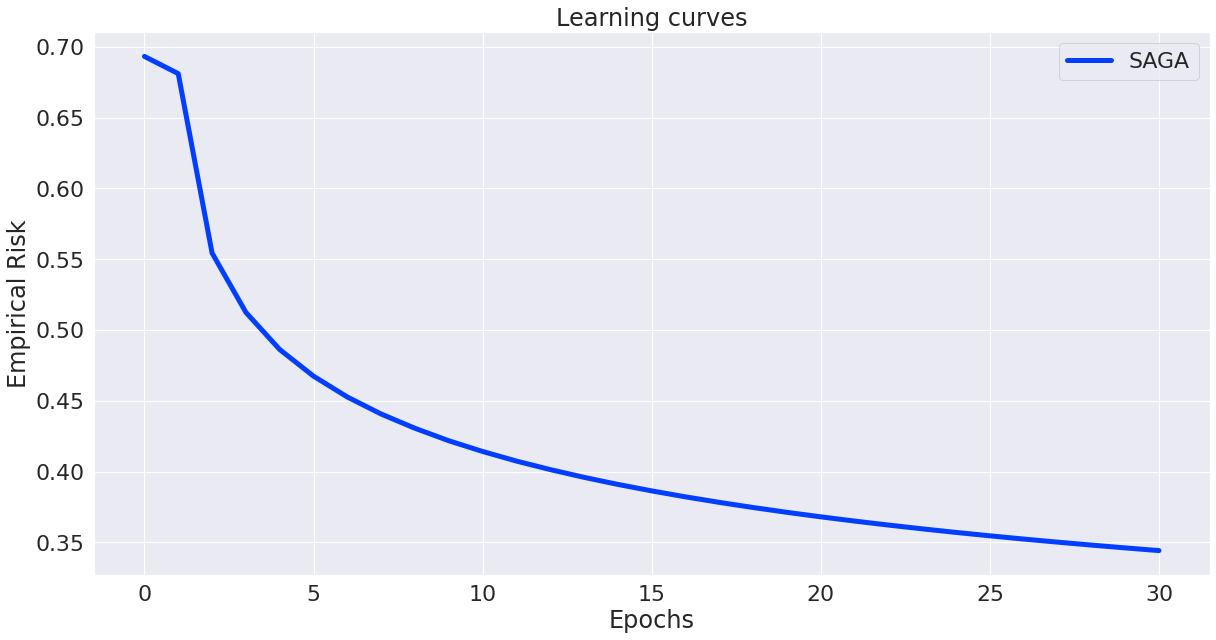

In [96]:
clf_saga = LogisticRegression(solver='saga', l2=0.01, max_iter=30*len(b_train))
clf_saga.fit(A_train, b_train)

learning_curve(SAGA=clf_saga)

# Comparison

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> Run the code below to compare all the methods you've implemented.
</div>

In [97]:
epochs = 50
n = len(b_train)

clf_gd   = LogisticRegression(solver='gd', l2=0.01, max_iter=epochs)
clf_sgd  = LogisticRegression(solver='sgd', l2=0.01, max_iter=epochs*n)
clf_saga = LogisticRegression(solver='saga', l2=0.01, max_iter=epochs*n)

clf_gd.fit(A_train, b_train)
clf_sgd.fit(A_train, b_train)
clf_saga.fit(A_train, b_train)

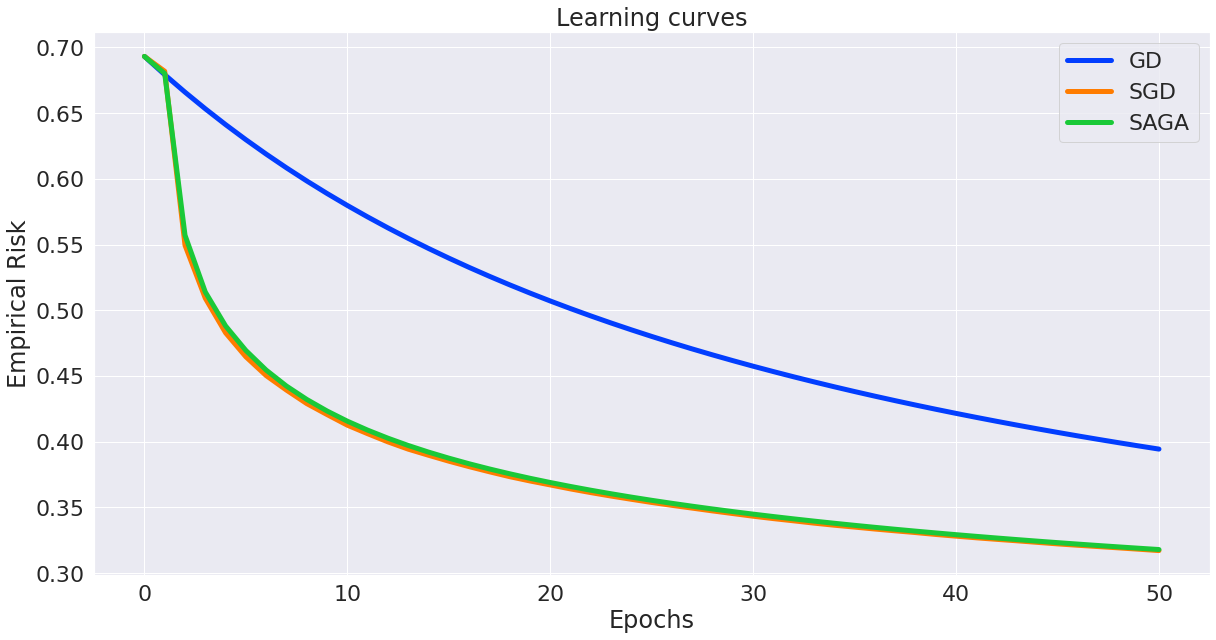

gd:	Accuracy on training set: 89.2%
	Accuracy on testing set:  86.9%
sgd:	Accuracy on training set: 90.9%
	Accuracy on testing set:  86.9%
saga:	Accuracy on training set: 89.9%
	Accuracy on testing set:  85.9%


In [98]:
learning_curve(GD=clf_gd, SGD=clf_sgd, SAGA=clf_saga)

for clf, name in zip([clf_gd, clf_sgd, clf_saga], ['gd', 'sgd', 'saga']):
    print(name + ':' \
          + "\tAccuracy on training set: {0:0.1f}%".format(100*clf.score(A_train, b_train)))
    print("\tAccuracy on testing set:  {0:0.1f}%".format(100*clf.score(A_test, b_test)))

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>IV. Regularization</h1>
</div>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> 
    <ul>
        <li> Rewrite the empirical risk minimization objective with both $L_1$ and $L_2$ regularization (with coefficients $l_1$ and $l_2$).</li>
        <li> Is this objective $\mu$-strongly convex, $L$-smooth, differentiable?</i>
        <li> Complete the <b>TODO (6)</b> to account for the new term in the objective.</i>
        <li> Add your code to <code>lib/regularize.py</code>.</i>
    </ul>
</div>

The minimization algorithms we've implemented have a slow rate of convergence for this new objective function. We will therefore use *proximal* variations of these algorithms.

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> Using the $\textrm{prox}_{l_1 \|\cdot\|_1}$ operator, write down the $k^{th}$ step of proximal GD, proximal SGD, and proximal SAGA.
</div>

$\textrm{prox}_{l_1 \|\cdot\|_1}$

We now turn to what we did on the last session:

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> 
    <ul>
        <li> Give a closed-form expression of $\textrm{prox}_{l_1 \|\cdot\|_1}$</li>
        <li> Complete <b>TODO (7)</b> (note that you can access the $l_1$ coefficient using <b>self.l1</b>).</li>
        <li> Add your code to <code>lib/linear_model.py</code>.</li>
    </ul>
</div>

In [99]:
epochs = 50
n = len(b_train)

clf_gd   = LogisticRegression(solver='gd', l2=0.01, l1=0.01, max_iter=epochs)
clf_sgd  = LogisticRegression(solver='sgd', l2=0.01, l1=0.01, max_iter=epochs*n)
clf_saga = LogisticRegression(solver='saga', l2=0.01, l1=0.01, max_iter=epochs*n)

clf_gd.fit(A_train, b_train)
clf_sgd.fit(A_train, b_train)
clf_saga.fit(A_train, b_train)

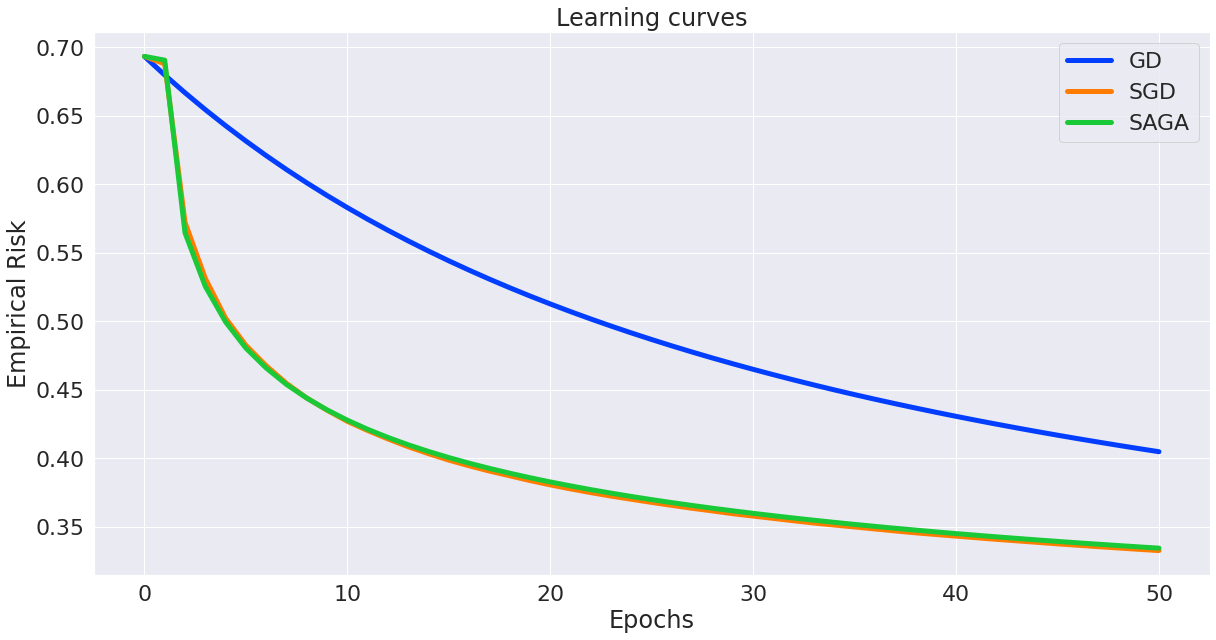

gd:	Accuracy on training set: 89.2%
	Accuracy on testing set:  86.9%
sgd:	Accuracy on training set: 90.9%
	Accuracy on testing set:  85.9%
saga:	Accuracy on training set: 90.2%
	Accuracy on testing set:  86.9%


In [100]:
learning_curve(GD=clf_gd, SGD=clf_sgd, SAGA=clf_saga)

for clf, name in zip([clf_gd, clf_sgd, clf_saga], ['gd', 'sgd', 'saga']):
    print(name + ':' \
          + "\tAccuracy on training set: {0:0.1f}%".format(100*clf.score(A_train, b_train)))
    print("\tAccuracy on testing set:  {0:0.1f}%".format(100*clf.score(A_test, b_test)))

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> If your proximal gradient is correctly implemented, the following cell plots the support of the solution for various values of $l_1$.
    <ul>
        <li> Interpret the plot and explain what can $L_1$ regularization be used for.</li>
    </ul>
</div>

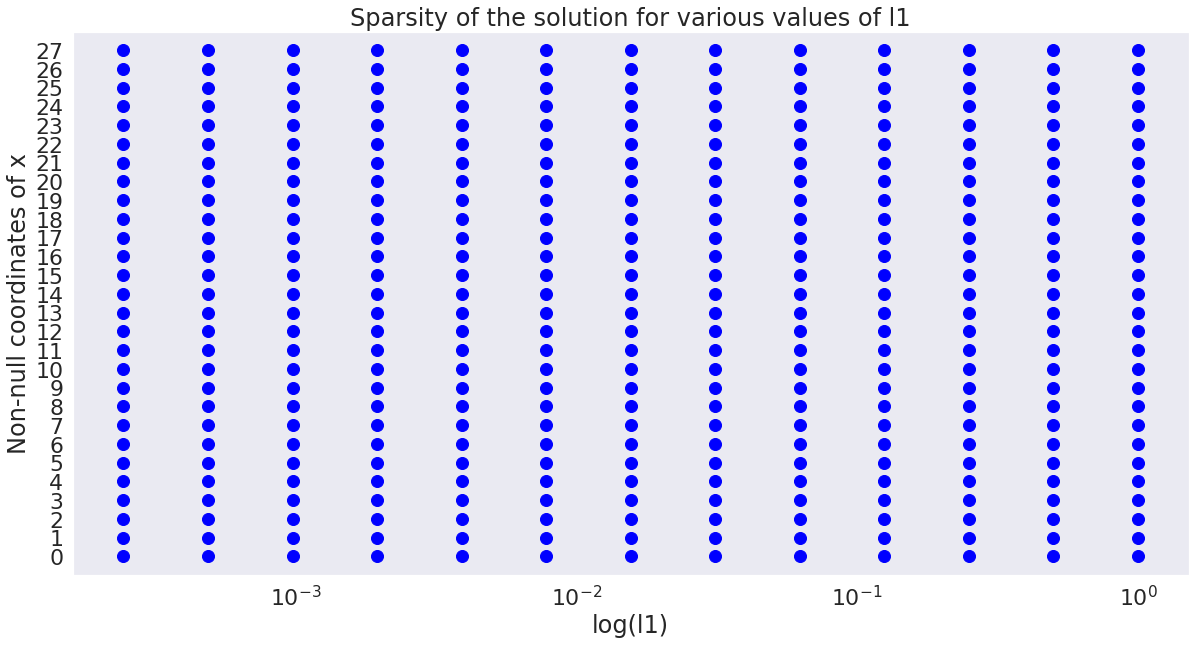

In [101]:
from lib.visuals import l1_regularization_plot

clf = lambda l1: LogisticRegression(solver='gd', l1=l1, l2=0.1, max_iter=1000)

l1_regularization_plot(clf, A_train, b_train)

> **Answer:**
>

<div style="background-color: #e1f5fe;  border-left: 5px solid #2962ff; padding: 0.5em; color: black;"> 
<b style="color: #2962ff;">Question:</b> The following cell will plot the value of the coordinates of the solution for various values of $l_2$.
    <ul>
        <li> Interpret the plot and explain what can $L_2$ regularization be used for.</li>
    </ul>
</div>

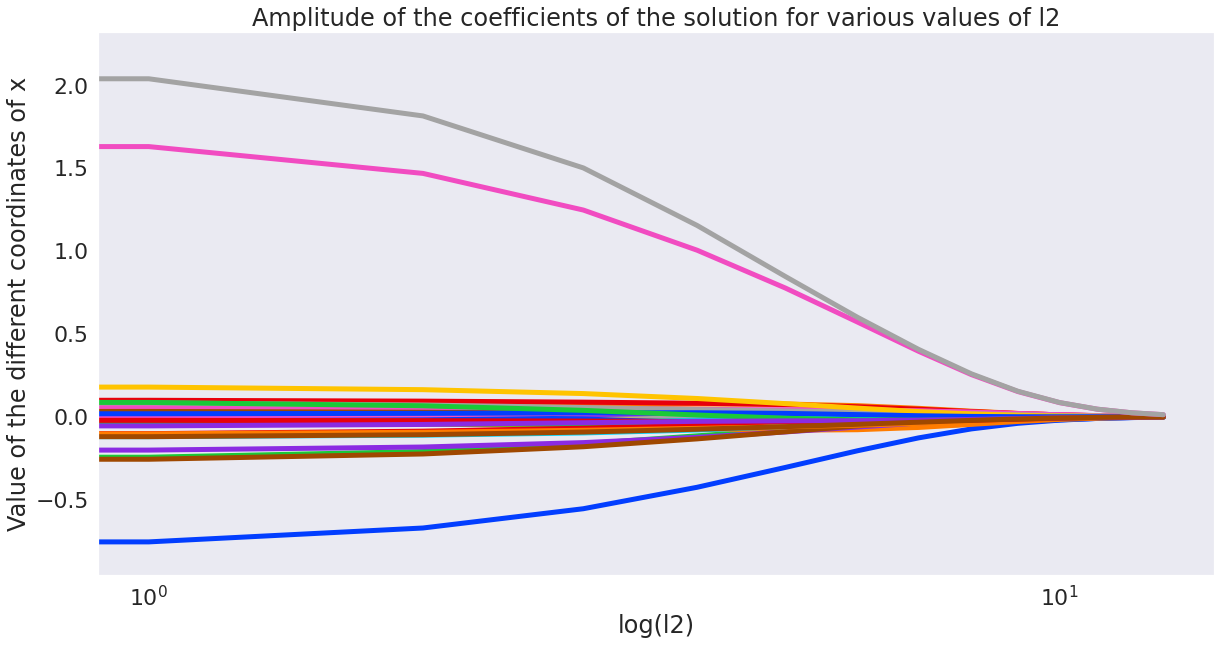

In [102]:
from lib.visuals import l2_regularization_plot

clf = lambda l2: LogisticRegression(solver='gd', l1=0.01, l2=l2, max_iter=1000)

l2_regularization_plot(clf, A_train, b_train)

> **Answer:**
>

<br>
<div style="color: #ffffff; background-color: #2979ff; border-bottom: 5px solid #004ecb; padding: 2em;"> 
<h1>V. Further development</h1>
</div>

Depending on your time left, we would encourage you to consider going beyond these questions so that you develop certain aspects, depending on your personal interests and skills. For instance:
- Implementations and numerical tests (further developments, more experiments, etc.)
- Applications in learning or statistics (interpretation of some results, other models, other datasets, etc.)
- Theoretical or mathematical questions (convergence proofs, convergence rates, advanced versions of an algorithm, theoretical analysis of special cases, etc.) 